### Importing library

In [380]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [381]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten
from keras.callbacks import EarlyStopping

In [382]:
from matplotlib import rcParams
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelweight'] = 'bold'
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'STIXGeneral:italic'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

In [383]:
def split_data(data, n_input, n_out): 
    in_start = 0
    X, y = list(), list()   
    for _ in range(len(data)):
        
        in_end = in_start + n_input
        out_end = in_end + n_out
        
        if out_end < len(data):
            X.append(data[in_start:in_end])
            y.append(data[in_end:out_end])
        
        in_start += n_out
    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0], y.shape[1])

In [384]:
np.random.seed(100)

### Load dataset
Dataset have been downloaded from [Digital Ocean](https://digitalocean.ie/Data/DownloadWaveData/SmartBay%20Wave%20Buoy), whith duration 2 years (Jan 2015 - Jan 2016)

In [387]:
dataset = pd.read_csv('galway2th.csv', names=['hs'])

nan = np.nan
dataset = dataset.interpolate(methode='cubic') # INTERPOLATING DATA

hs = dataset

### Standardize the data

In [388]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_hs = scaler.fit_transform(hs)

Text(0, 0.5, 'Hs [m]')

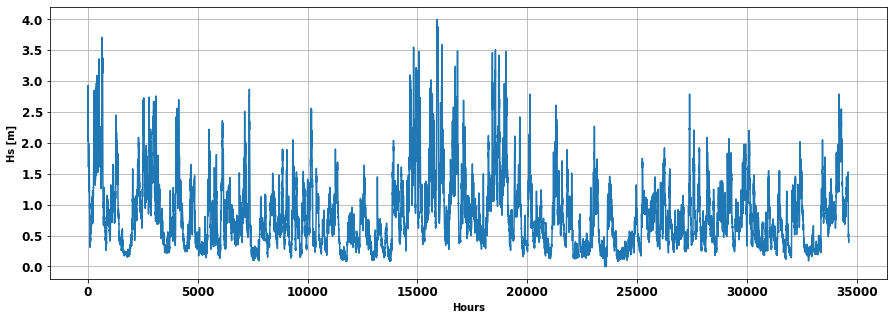

In [389]:
plt.figure(figsize=(15,5))
plt.plot(hs)
plt.grid()
plt.xlabel('Hours')
plt.ylabel('Hs [m]')


In [390]:
n_train = int(len(scaled_hs)*0.70)
n_test = len(scaled_hs) - n_train
train, test = scaled_hs[0:n_train, :], scaled_hs[n_train:len(scaled_hs),:]

### Building input data

In [391]:
look_back = 12 # number of input data in previous time step
n_out = 1
trainX, trainY = split_data(train, look_back, n_out)
testX, testY = split_data(test, look_back, n_out)

In [392]:
pd.DataFrame(trainX).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.5075,0.5225,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125
1,0.5225,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125
2,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875
3,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875,0.5625
4,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875,0.5625,0.5575


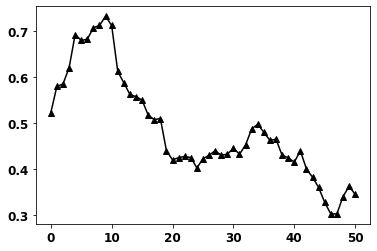

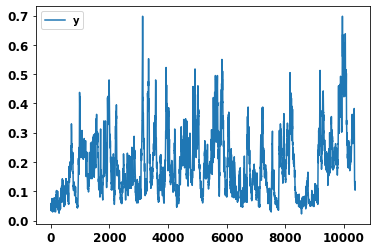

In [393]:
plt.figure(1)
plt.plot(train[1:52], marker='^', color='black', label='X')
plt.figure(2)
plt.plot(testY, label='y')
plt.legend()
plt.show()

In [394]:
trainX.shape[0]

24230

### Reshaping data (1D - 3D)
In LSTM, the input data should be 3D (sample, time step, feature)
LSTM mengharuskan inputnya berbentuk 3D (samples, time step, feature).

In [395]:
trainX_r = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1)) # Baris - timestep - kolom
trainY_r = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
testX_r = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
testY_r = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX_r.shape, trainY.shape)

(24230, 12, 1) (24230, 1)


### LSTM Model

In [396]:
from keras.layers import TimeDistributed, RepeatVector

batch_size=1
model = Sequential()
model.add(Bidirectional(LSTM(40, activation='tanh', input_shape=(trainX.shape[1], 1),
                             batch_input_shape=(batch_size, look_back, 1))))
model.add(RepeatVector(trainY.shape[1]))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', dropout=0.3, recurrent_regularizer='l2', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='nadam', loss='mse')


In [397]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=10, verbose=0, mode='auto', 
                           baseline=None, restore_best_weights=False)]

history = model.fit(trainX_r, trainY_r, 
                    validation_split=0.1, 
                    epochs = 20, batch_size=10, 
                    verbose=1, 
                    callbacks = callbacks)


Train on 21807 samples, validate on 2423 samples
Epoch 1/20
21807/21807 [==============================] - 169s 8ms/step - loss: 0.0110 - val_loss: 1.2446e-04
Epoch 2/20
21807/21807 [==============================] - 164s 8ms/step - loss: 5.2288e-04 - val_loss: 1.8803e-04
Epoch 3/20
21807/21807 [==============================] - 165s 8ms/step - loss: 4.7285e-04 - val_loss: 1.1241e-04
Epoch 4/20
21807/21807 [==============================] - 164s 8ms/step - loss: 4.4108e-04 - val_loss: 2.3572e-04
Epoch 5/20
21807/21807 [==============================] - 165s 8ms/step - loss: 4.1454e-04 - val_loss: 1.4328e-04
Epoch 6/20
21807/21807 [==============================] - 163s 7ms/step - loss: 4.1252e-04 - val_loss: 2.4043e-04
Epoch 7/20
21807/21807 [==============================] - 164s 8ms/step - loss: 4.0458e-04 - val_loss: 1.4839e-04
Epoch 8/20
21807/21807 [==============================] - 170s 8ms/step - loss: 4.0094e-04 - val_loss: 1.5152e-04
Epoch 9/20
21807/21807 [===================

In [399]:
trainPredict = model.predict(trainX_r)
testPredict = model.predict(testX_r)

In [401]:
#trainPredict = scaler.inverse_transform(trainPredict.reshape(trainPredict.shape[0], trainPredict.shape[1]))
#trainY = scaler.inverse_transform(trainY.reshape(trainY.shape[0], trainY.shape[1]))
#testPredict = scaler.inverse_transform(testPredict.reshape(testPredict.shape[0], testPredict.shape[1]))
#testY = scaler.inverse_transform(testY.reshape(testY.shape[0], testY.shape[1]))

### Evaluate the model

In [403]:
rmse_train = math.sqrt(mean_squared_error(trainY_r.flatten(), trainPredict.flatten()))
rmse_test = math.sqrt(mean_squared_error(testY_r.flatten(), testPredict.flatten()))
bias_train = np.mean(trainPredict.flatten() - trainY.flatten())
bias_test = np.mean(testPredict.flatten() - testY.flatten())

print('RMSE Train data : %.2f cm' %(rmse_train*100))
print('RMSE Test data : %.2f cm' %(rmse_test*100))
print('Bias Train :', bias_train)
print('Bias Test : ', bias_test)

RMSE Train data : 1.65 cm
RMSE Test data : 1.23 cm
Bias Train : 0.00272488916930068
Bias Test :  0.002337629693646632


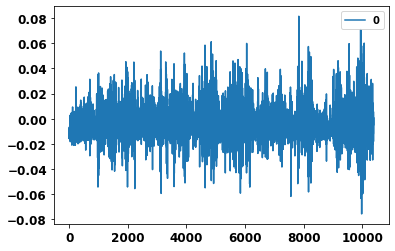

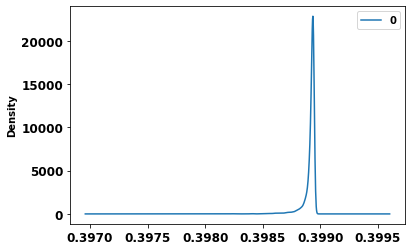

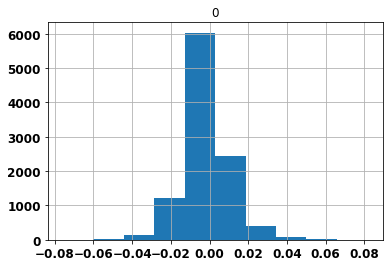

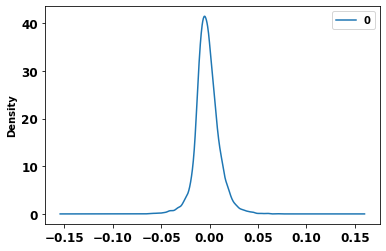

In [406]:
from scipy.stats import norm

residual_test = pd.DataFrame(testY.flatten() - testPredict.flatten())
residual_test.plot()
m, s = norm.fit(residual_test)
#dist_norm = pd.DataFrame(norm.pdf(residual_test, m, s))
dist_norm = pd.DataFrame(norm.pdf(residual_test))
dist_norm.plot(kind='kde')
plt.show()
residual_test.hist()
residual_test.plot(kind='kde')
plt.show()

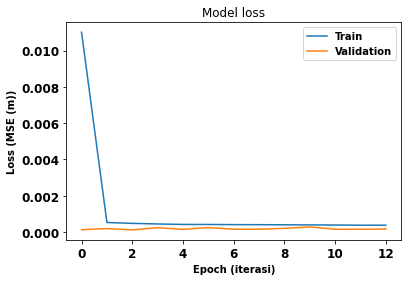

In [407]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE (m))')
plt.xlabel('Epoch (iterasi)')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Visualize the result

In [408]:
# data for plot
trainPredictPlot = np.empty_like(hs) # membuat matriks kosong dgn dimensi sama seperti raw data
trainPredictPlot[:,:] = np.nan # mengisi matriks tsb dgn NaN
trainPredictPlot[look_back:len(trainPredict.flatten())+look_back, :] = np.array([trainPredict.flatten()]).T # mengsinkronkan skala dgn hasil prediksi

testPredictPlot = np.empty_like(hs)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict.flatten())+(look_back*2)+1 : len(hs)-1, :] = np.array([testPredict.flatten()]).T


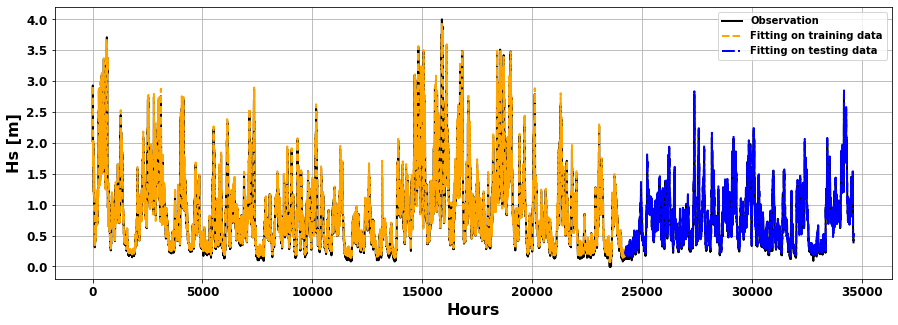

In [409]:
trainPredictPlot_inv = scaler.inverse_transform(trainPredictPlot.reshape(-1,1))
testPredictPlot_inv = scaler.inverse_transform(testPredictPlot.reshape(-1,1))

plt.figure(figsize=(15,5))
plt.plot(hs, linestyle = '-', color='black', marker='', linewidth =2, label='Observation')
plt.plot(trainPredictPlot_inv, linestyle = '--', marker='', color='orange', linewidth=2, label='Fitting on training data')
plt.plot(testPredictPlot_inv, linestyle = '-.', marker='', color='blue', linewidth=2, label='Fitting on testing data')

plt.xlabel('Hours', fontsize=16)
plt.ylabel('Hs [m]', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

In [426]:
def predict_hs(input_pred, look_back, n_out):
  
  last_lb = input_pred
  pred_out = list()

  ni = 0
  for i in range(0, int(12/n_out)): # 48 hours multi-step prediction
    last_lb_r = last_lb.reshape(1, look_back, 1) # (n_example, n_timestep, n_feature)
    pred = model.predict(last_lb_r)
    last_lb = np.append(last_lb, pred)
    last_lb = np.array([last_lb])
    ni = n_out
    last_lb = last_lb[:, ni:]
    pred.tolist()
    pred_out.extend(pred)

  pred_out = np.array(pred_out)
  pred_out = pred_out.reshape(pred_out.shape[0],pred_out.shape[1])
  pred_out = pred_out.flatten()

  return pred_out


In [411]:
def plot_predict(input_pred, pred_out, obs_data):

  f = np.linspace(1,72,72)

  onx = np.array([pred_out]).shape[1]
  obs = obs_data.flatten()

  plt.figure(figsize=(15,6))
  plt.plot(f[:onx], pred_out, linestyle='-', marker='o', color='blue', label='Predicted') #o
  plt.plot(f[:onx], obs, linestyle='-', marker='^', color='black', label='Observation') #^
  plt.xlabel('Hours',fontweight='bold', fontsize=16)
  plt.ylabel('$\it{Hs}$ (m)', fontweight='bold', fontsize=16)
  #plt.ylim(0, 2)
  plt.legend()
  plt.grid()

Sampel Prediction on Testing Data



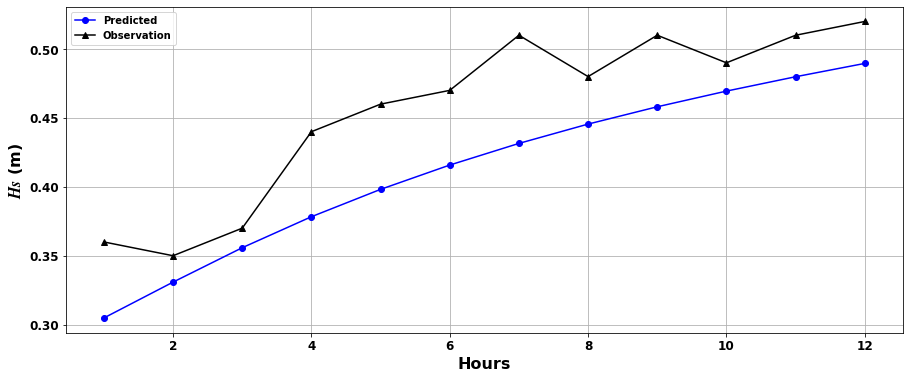

In [433]:
print('Sampel Prediction on Testing Data\n')
sam = 1772
look_back = testX.shape[1]
pred_sam = predict_hs(testX[sam], look_back, n_out)

# rescaling data into original
testY_inv = scaler.inverse_transform(testY)
obs_sam_inv = testY_inv[sam:sam+12]
pred_sam_inv = scaler.inverse_transform(np.array(pred_sam).reshape(-1,1))
plot_predict(testX[sam], pred_sam_inv, obs_sam_inv) 

In [434]:
obs_sam = testY_inv[sam:sam+12].flatten() 
rmse_pred = math.sqrt(np.mean((pred_sam_inv-obs_sam)**2))
print('RMSE sampel:', rmse_pred*100,'cm')

from scipy.stats import pearsonr

korelasi = pearsonr(pred_sam, obs_sam)
print('Korelasi, p-value:', korelasi)
print('Bias:',np.mean(pred_sam_inv-obs_sam))

RMSE sampel: 9.347903191345347 cm
Korelasi, p-value: (0.9449161750110319, 3.6397918155815744e-06)
Bias: -0.04268089443445206


In [ ]:
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelweight'] = 'bold'
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

rcParams['legend.fontsize'] = 16

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'STIXGeneral:italic'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

### Multi-step prediction 12 hours

In [430]:
# untuk prediksi 12 jam
pred_out2c = predict_hs(testX[1760], look_back, n_out) #1760 - 2070
pred_out2c_inv = scaler.inverse_transform(np.array(pred_out2c).reshape(-1,1))
pred_out3c = predict_hs(testX[1772], look_back, n_out)
pred_out3c_inv = scaler.inverse_transform(np.array(pred_out3c).reshape(-1,1))
pred_out4c = predict_hs(testX[1784], look_back, n_out)
pred_out4c_inv = scaler.inverse_transform(np.array(pred_out4c).reshape(-1,1))
pred_out5c = predict_hs(testX[1796], look_back, n_out)
pred_out5c_inv = scaler.inverse_transform(np.array(pred_out5c).reshape(-1,1))
pred_out6c = predict_hs(testX[1808], look_back, n_out)
pred_out6c_inv = scaler.inverse_transform(np.array(pred_out6c).reshape(-1,1))
pred_out7c = predict_hs(testX[1820], look_back, n_out)
pred_out7c_inv = scaler.inverse_transform(np.array(pred_out7c).reshape(-1,1))
pred_out8c = predict_hs(testX[1832], look_back, n_out)
pred_out8c_inv = scaler.inverse_transform(np.array(pred_out8c).reshape(-1,1))
pred_out9c = predict_hs(testX[1844], look_back, n_out)
pred_out9c_inv = scaler.inverse_transform(np.array(pred_out9c).reshape(-1,1))
pred_out10c = predict_hs(testX[1856], look_back, n_out)
pred_out10c_inv = scaler.inverse_transform(np.array(pred_out10c).reshape(-1,1))
pred_out11c = predict_hs(testX[1868], look_back, n_out)
pred_out11c_inv = scaler.inverse_transform(np.array(pred_out11c).reshape(-1,1))
pred_out12c = predict_hs(testX[1880], look_back, n_out)
pred_out12c_inv = scaler.inverse_transform(np.array(pred_out12c).reshape(-1,1))
pred_out13c = predict_hs(testX[1892], look_back, n_out)
pred_out13c_inv = scaler.inverse_transform(np.array(pred_out13c).reshape(-1,1))
pred_out14c = predict_hs(testX[1904], look_back, n_out)
pred_out14c_inv = scaler.inverse_transform(np.array(pred_out14c).reshape(-1,1))
pred_out15c = predict_hs(testX[1916], look_back, n_out)
pred_out15c_inv = scaler.inverse_transform(np.array(pred_out15c).reshape(-1,1))
pred_out16c = predict_hs(testX[1928], look_back, n_out)
pred_out16c_inv = scaler.inverse_transform(np.array(pred_out16c).reshape(-1,1))
pred_out17c = predict_hs(testX[1940], look_back, n_out)
pred_out17c_inv = scaler.inverse_transform(np.array(pred_out17c).reshape(-1,1))
pred_out18c = predict_hs(testX[1952], look_back, n_out)
pred_out18c_inv = scaler.inverse_transform(np.array(pred_out18c).reshape(-1,1))
pred_out19c = predict_hs(testX[1964], look_back, n_out)
pred_out19c_inv = scaler.inverse_transform(np.array(pred_out19c).reshape(-1,1))
pred_out20c = predict_hs(testX[1976], look_back, n_out)
pred_out20c_inv = scaler.inverse_transform(np.array(pred_out20c).reshape(-1,1))
pred_out21c = predict_hs(testX[1988], look_back, n_out)
pred_out21c_inv = scaler.inverse_transform(np.array(pred_out21c).reshape(-1,1))
pred_out22c = predict_hs(testX[2000], look_back, n_out)
pred_out22c_inv = scaler.inverse_transform(np.array(pred_out22c).reshape(-1,1))
pred_out23c = predict_hs(testX[2012], look_back, n_out)
pred_out23c_inv = scaler.inverse_transform(np.array(pred_out23c).reshape(-1,1))
pred_out24c = predict_hs(testX[2024], look_back, n_out)
pred_out24c_inv = scaler.inverse_transform(np.array(pred_out24c).reshape(-1,1))
pred_out25c = predict_hs(testX[2036], look_back, n_out)
pred_out25c_inv = scaler.inverse_transform(np.array(pred_out25c).reshape(-1,1))
pred_out26c = predict_hs(testX[2048], look_back, n_out)
pred_out26c_inv = scaler.inverse_transform(np.array(pred_out26c).reshape(-1,1))
pred_out27c = predict_hs(testX[2060], look_back, n_out)
pred_out27c_inv = scaler.inverse_transform(np.array(pred_out27c).reshape(-1,1))
pred_out28c = predict_hs(testX[2072], look_back, n_out)
pred_out28c_inv = scaler.inverse_transform(np.array(pred_out28c).reshape(-1,1))
pred_out29c = predict_hs(testX[2084], look_back, n_out)
pred_out29c_inv = scaler.inverse_transform(np.array(pred_out29c).reshape(-1,1))

In [431]:
def plot_predict_all12(input_pred, pred_out, obs_data, pred_out2, pred_out3, pred_out4, pred_out5, pred_out6, pred_out7,
                     pred_out8, pred_out9, pred_out10, pred_out11, pred_out12, pred_out13, pred_out14, pred_out15, pred_out16,
                     pred_out17, pred_out18, pred_out19, pred_out20, pred_out21, pred_out22, pred_out23, pred_out24, pred_out25,
                     pred_out26, pred_out27, pred_out28, pred_out29):
  
  # Prediksi Hs 12 time step (12 jam) kedepan
  #pred_moving = pred_hs(24)
  f = np.linspace(1,15000,15000)
  inx = np.array([testY[:50]]).flatten().shape[0]
  inx2 = np.array([testY[:1760-1759]]).flatten().shape[0]
  inx3 = np.array([testY[:1772-1759]]).flatten().shape[0]
  inx4 = np.array([testY[:1784-1759]]).flatten().shape[0]
  inx5 = np.array([testY[:1796-1759]]).flatten().shape[0]
  inx6 = np.array([testY[:1808-1759]]).flatten().shape[0]
  inx7 = np.array([testY[:1820-1759]]).flatten().shape[0]
  inx8 = np.array([testY[:1832-1759]]).flatten().shape[0]
  inx9 = np.array([testY[:1844-1759]]).flatten().shape[0]
  inx10 = np.array([testY[:1856-1759]]).flatten().shape[0]
  inx11 = np.array([testY[:1868-1759]]).flatten().shape[0]
  inx12 = np.array([testY[:1880-1759]]).flatten().shape[0]
  inx13 = np.array([testY[:1892-1759]]).flatten().shape[0]
  inx14 = np.array([testY[:1904-1759]]).flatten().shape[0]
  inx15 = np.array([testY[:1916-1759]]).flatten().shape[0]
  inx16 = np.array([testY[:1928-1759]]).flatten().shape[0]
  inx17 = np.array([testY[:1940-1759]]).flatten().shape[0]
  inx18 = np.array([testY[:1952-1759]]).flatten().shape[0]
  inx19 = np.array([testY[:1964-1759]]).flatten().shape[0]
  inx20 = np.array([testY[:1976-1759]]).flatten().shape[0]
  inx21 = np.array([testY[:1988-1759]]).flatten().shape[0]
  inx22 = np.array([testY[:2000-1759]]).flatten().shape[0]
  inx23 = np.array([testY[:2012-1759]]).flatten().shape[0]
  inx24 = np.array([testY[:2024-1759]]).flatten().shape[0]
  inx25 = np.array([testY[:2036-1759]]).flatten().shape[0]
  inx26 = np.array([testY[:2048-1759]]).flatten().shape[0]
  inx27 = np.array([testY[:2060-1759]]).flatten().shape[0]
  inx28 = np.array([testY[:2072-1759]]).flatten().shape[0]
  inx29 = np.array([testY[:2084-1759]]).flatten().shape[0]

  #onx = np.array([testY[]]).shape[1]
  obs = obs_data.flatten()
  obs_plot = obs[1760:2096]

  plt.figure(figsize=(16,6))
  plt.plot(f[1760-1759:2096-1759], obs_plot, linestyle='-.', color='black', marker='o', markerfacecolor='none', markeredgecolor='black', label='Observation')
  #plt.plot(f[inx:inx+48], pred_out, linestyle='-.', color='red', marker='o', markerfacecolor='none', markeredgecolor='red', label='Prediksi')
  plt.plot(f[inx2:inx2+12], pred_out2[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue',label='Prediction')
  plt.plot(f[inx3:inx3+12], pred_out3, linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx4:inx4+12], pred_out4[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx5:inx5+12], pred_out5[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx6:inx6+12], pred_out6[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx7:inx7+12], pred_out7[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx8:inx8+12], pred_out8[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx9:inx9+12], pred_out9[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx10:inx10+12], pred_out10[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx11:inx11+12], pred_out11[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx12:inx12+12], pred_out12[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx13:inx13+12], pred_out13[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx14:inx14+12], pred_out14[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx15:inx15+12], pred_out15, linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx16:inx16+12], pred_out16[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx17:inx17+12], pred_out17[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx18:inx18+12], pred_out18[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx19:inx19+12], pred_out19[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx20:inx20+12], pred_out20[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx21:inx21+12], pred_out21[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx22:inx22+12], pred_out22[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx23:inx23+12], pred_out23[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx24:inx24+12], pred_out24[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx25:inx25+12], pred_out25[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx26:inx26+12], pred_out26[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx27:inx27+12], pred_out27[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx28:inx28+12], pred_out28[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')
  plt.plot(f[inx29:inx29+12], pred_out29[:12], linestyle='-.', color='blue', marker='o', markerfacecolor='none', markeredgecolor='blue')

  plt.xlabel('Hours', fontweight='bold', fontsize=16)
  plt.ylabel('$\it{Hs}$ [m]', fontweight='bold', fontsize=16)
  plt.ylim(0, 2.5)
  plt.grid(True)
  plt.legend(loc='upper right')
  plt.show()  

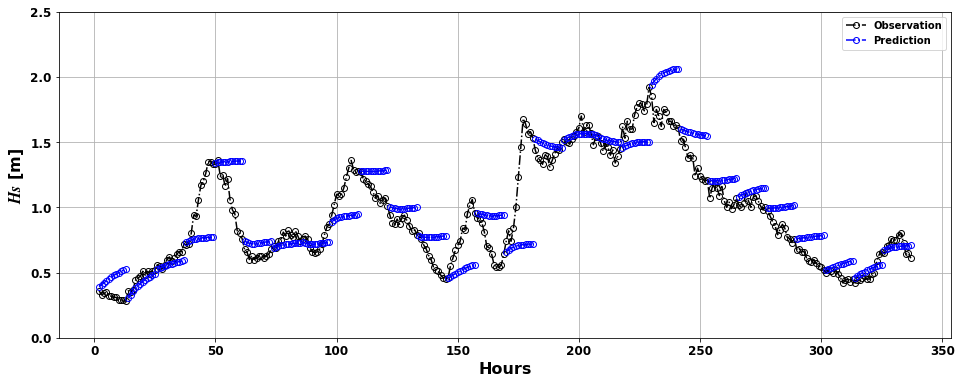

In [432]:
plot_predict_all12(testY_inv[:sam], pred_sam, testY_inv, pred_out2c_inv, pred_out3c_inv, pred_out4c_inv, pred_out5c_inv, pred_out6c_inv, pred_out7c_inv,
                   pred_out8c_inv, pred_out9c_inv, pred_out10c_inv, pred_out11c_inv, pred_out12c_inv, pred_out13c_inv, pred_out14c_inv, pred_out15c_inv,
                   pred_out16c_inv, pred_out17c_inv, pred_out18c_inv, pred_out19c_inv, pred_out20c_inv, pred_out21c_inv, pred_out22c_inv,
                   pred_out23c_inv, pred_out24c_inv, pred_out25c_inv, pred_out26c_inv, pred_out27c_inv, pred_out28c_inv, pred_out29c_inv)